# Capstone Project 1: Data Story

In this section, I present a priliminary exploration of the data for capstone project. I begin with the data <i>csv</i> file we obtained after the data wrangling section. As a recall, the data contains mostly categorical variables and components of the vectors from the description column. The index column is a <i>timeseries</i> format. 

The major objective of this section is to understand the general trends in the data, and gain some quick insights and relation between variables that will help in machine learning later. The statistical significance of these observation will be tested in the next section <b> Exploratory Data Analysis</b>. 

In [383]:
# Import necessary modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

# Read the accident data from csv
df_traffic = pd.read_csv('data_wrangled.csv', 
                           index_col = 'Date Of Stop_Time Of Stop',
                           parse_dates = True,
                           infer_datetime_format = True)

Every months, there are around 15, 000 violations take place in Montgomery county, which amounts to one violations in every three minutes. But this number varies with season. More violation takes place in summer (June - Aug) compared to spring (Mar - May). Similarly, more violations occur in late night (after 10 pm) rather than the busy traffic hours. Both of these observations suggest that police officers become more stringent when the traffic is less dense. It is also possible that officers are busy on other activities during the peak hours.  

Among weekdays, violations are peaked on Tuesday and that drops slowly until the end of the week. It is interesting why number of violations on Monday is similar to the weekends. 

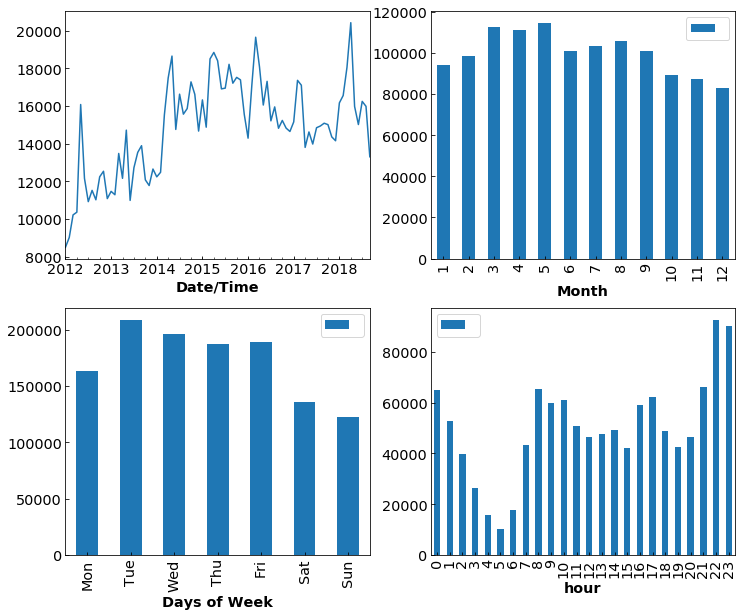

In [384]:
fig, axes = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize = [12, 10])

df_mon = df_traffic.resample('M').count()
df_mon.index.names = ['Date/Time']
df_mon.Belts_Yes.plot(ax = axes[0,0])

# Traffic violation by month
df_traffic['datetime'] = df_traffic.index
df_traffic['Month'] = df_traffic.datetime.dt.month

df_count_by_month = df_traffic.groupby('Month').count()

df_count_by_month.plot(kind = 'bar', y = 'Belts_Yes', label = '', ax = axes[0,1])
plt.ylabel('Violations')

# Traffic violation by day
df_traffic['day'] = df_traffic.datetime.dt.dayofweek
df_count_by_month = df_traffic.groupby('day').count()
df_count_by_month.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
df_count_by_month.index.names = ['Days of Week']

df_count_by_month.plot(kind = 'bar', y = 'Belts_Yes', label = '', ax = axes[1,0])
plt.xlabel('Day of Week')

# Traffic violation by hour
df_traffic['hour'] = df_traffic.datetime.dt.hour

df_count_by_month = df_traffic.groupby('hour').count()

df_count_by_month.plot( kind = 'bar', y = 'Belts_Yes', label = '', ax = axes[1,1])
plt.ylabel('')
plt.show()


### Citation probability: 

Not all the violations end up to citations. Some lucky drivers manage to receive just a warning, which gives them a great relief from paying an expensive fee or going to a court. In an ideal world, the probability of a driver getting a citation should only depend on the degree of violations he/she commits. But like every other human beings, police officers are biased on the drivers race, gender and the age of the vehicle. To quantitatively analyse the biasness of police officers on different socio/economic classes, I define a term <b>Citation Probability ($C_p$)</b>, which is a probability that a particular category gets citation after getting pulled over. 

\begin{equation*}
Cp   = \frac{N_c}{N_c + N_w}
\end{equation*}

where, $N_c$ and $N_w$ are respectively number of citations and number of warnings received by the driver belonging to a particular subgroup of a particular category. Below is a plot of citation probability for a few different categories.

The figure below display some useful comparisions: The police officers are biased against Male drivers and drivers other than Whites. Also, they give more citation to the older vehicles compared to the new vehicles. 

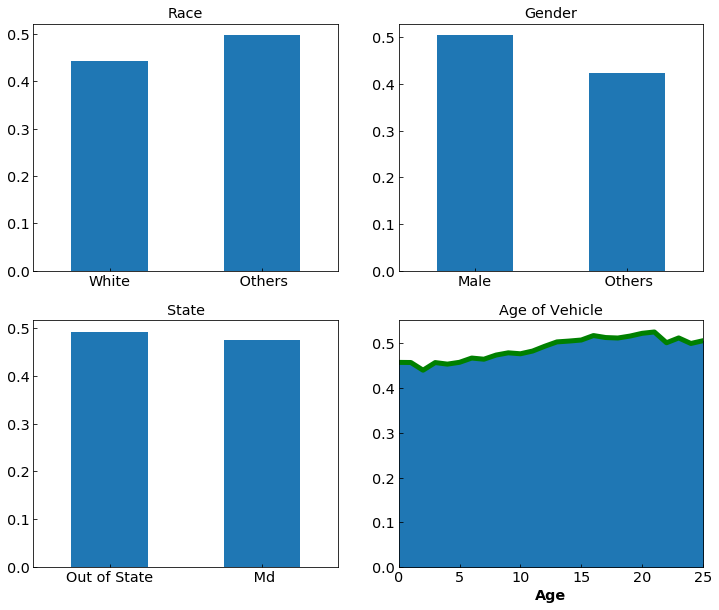

In [185]:
# initialize subplots
fig, axes = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize = [12, 10])

# plot the citation probability vs race
df = df_traffic.groupby(['Race_non_white', 'Violation Type_Warning']).count()

prop_non_white = df.loc[(1, 0),'Belts_Yes']/\
                    [df.loc[(1, 0),'Belts_Yes'] +\
                     df.loc[(1, 1),'Belts_Yes']]
prop_white = df.loc[(0, 0),'Belts_Yes']/\
                    [df.loc[(0, 0),'Belts_Yes'] +\
                     df.loc[(0, 1),'Belts_Yes']]

df1 = pd.DataFrame([prop_white, prop_non_white], index = ['White', ' Others'])
s1 = df1.plot(kind = 'bar', legend = False, rot = 0, ax  = axes[0,0], title = 'Race')

# plot the citation probability vs Gender
df = df_traffic.groupby(['Gender_M', 'Violation Type_Warning']).count()

prop_female = df.loc[(0, 0),'Belts_Yes']/\
                    [df.loc[(0, 0),'Belts_Yes'] +\
                     df.loc[(0, 1),'Belts_Yes']]
prop_male = df.loc[(1, 0),'Belts_Yes']/\
                    [df.loc[(1, 0),'Belts_Yes'] +\
                     df.loc[(1, 1),'Belts_Yes']]

df1 = pd.DataFrame([prop_male, prop_female], index = ['Male', ' Others'])
s2 = df1.plot(kind = 'bar', legend = False, rot = 0, ax = axes[0,1], title = 'Gender')

# plot the citation probability of Driver's license driver
df_state = df_traffic.groupby(['DL State_Out-ofSTATE', 'Violation Type_Warning']).count()

prop_state = df_state.loc[(0, 0),'Belts_Yes']/\
                    [df_state.loc[(0, 0),'Belts_Yes'] +\
                     df_state.loc[(0, 1),'Belts_Yes']]
prop_outstate = df_state.loc[(1, 0),'Belts_Yes']/\
                    [df_state.loc[(1, 0),'Belts_Yes'] +\
                     df_state.loc[(1, 1),'Belts_Yes']]
    
df1 = pd.DataFrame([prop_outstate, prop_state], index = ['Out of State', ' Md'])
s3 = df1.plot(kind = 'bar', legend = False, rot = 0, ax = axes[1,0], title = "State")

# plot citation probability vs age of vehicle
df = df_traffic.groupby(['V_Age', 'Violation Type_Warning']).count()
ct_prob = list()

n = 25
ages = np.linspace(0,n, n+1)

for age in ages:
    citation = df.loc[(age, 0), 'Belts_Yes']
    warning = df.loc[(age, 1), 'Belts_Yes']
    prob = citation/(citation + warning)
    ct_prob.append(prob)

V_age = pd.DataFrame({'Age':ages, 'Cp': ct_prob})
s4 = V_age.plot(kind = 'area', x = 'Age', y = 'Cp', ax  = axes[1,1], title = 'Age of Vehicle', legend = False)
plt.xticks = np.arange(0,25,6)
V_age.plot(x = 'Age', y = 'Cp', color = 'g', ax  = axes[1,1], linewidth = 5, legend = False)
plt.tight_layout

plt.show()

The citation probability not only compares the bias among differnt social classes, but also useful to understand how police officers respond at certain condition. This can be easily understood from the citation probability of all the categorical features in our data. 

The figure below tells us that drunk drivers are extremely likely (almost 90%) of receiving a traffic citation. It is also natural that violation in workplace increases the risk of receiving a citation. 

The citation probability is higher in the weekends rather than a busy weekday. This is probably because traffic officers are more active chasing drivers when the traffic is less crowded. However, it is quite unexpected that the citation probability is lower for drivers who uses seatbelts. This simply tells that the traffic officers do not care much on the use of seatbelt. 

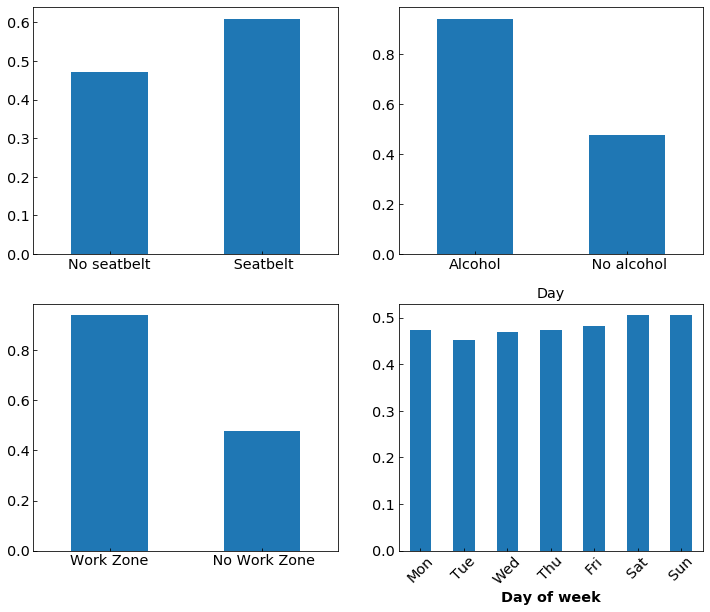

In [385]:
# initialize subplots
fig, axes = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize = [12, 10])

# Wearing seat belt decreases the citation probability
df = df_traffic.groupby(['Belts_Yes', 'Violation Type_Warning']).count()

prop_no_seatbelt = df.loc[(0, 0),'Personal Injury_Yes']/\
                    [df.loc[(0, 0),'Personal Injury_Yes'] + df.loc[(0, 1),'Personal Injury_Yes']]
prop_seatbelt = df.loc[(1, 0),'Personal Injury_Yes']/\
                    [df.loc[(1, 0),'Personal Injury_Yes'] + df.loc[(1, 1),'Personal Injury_Yes']]

df1 = pd.DataFrame([prop_no_seatbelt, prop_seatbelt], index = ['No seatbelt', ' Seatbelt'])
df1.plot(kind = 'bar', rot = 0, legend = False, ax = axes[0, 0])


# How does drinking alcochol effect the cp?
df = df_traffic.groupby(['Alcohol_Yes', 'Violation Type_Warning']).count()

prop_noalcohol = df.loc[(0, 0),'Belts_Yes']/\
                    [df.loc[(0, 0),'Belts_Yes'] + df.loc[(0, 1),'Belts_Yes']]
prop_alcohol = df.loc[(1, 0),'Belts_Yes']/\
                    [df.loc[(1, 0),'Belts_Yes'] + df.loc[(1, 1),'Belts_Yes']]

df1 = pd.DataFrame([prop_alcohol, prop_noalcohol], index = ['Alcohol', ' No alcohol'])
df1.plot(kind = 'bar', rot = 0, legend = False, ax = axes[0,1])

# is violation on work zone is different from other places?
df = df_traffic.groupby(['Work Zone_Yes', 'Violation Type_Warning']).count()

prop_work = df.loc[(0, 0),'Belts_Yes']/\
                    [df.loc[(0, 0),'Belts_Yes'] + df.loc[(0, 1),'Belts_Yes']]
prop_work = df.loc[(1, 0),'Belts_Yes']/\
                    [df.loc[(1, 0),'Belts_Yes'] + df.loc[(1, 1),'Belts_Yes']]

df1 = pd.DataFrame([prop_alcohol, prop_noalcohol], index = ['Work Zone', ' No Work Zone'])
df1.plot(kind = 'bar', rot = 0, legend = False, ax = axes[1,0])

# Is any day more likely to get tickets
df = df_traffic.groupby(['day', 'Violation Type_Warning']).count()

ct_prob = list()
for i in range(7):
    prob = df.loc[(i, 0),'Belts_Yes']/\
                 [df.loc[(i, 0),'Belts_Yes'] + df.loc[(i, 1),'Belts_Yes']]
        
    ct_prob.append(float(prob))

days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
df = pd.DataFrame({'Day': days, 'cp': ct_prob})
df.plot(kind = 'bar', y = 'cp', x = 'Day', title = 'Day', rot = 45,  legend = False, ax = axes[1,1])   
plt.xlabel('Day of week')

plt.show()


The figure above shows citation probability of few categories. In the case of no bias, I would expect that the $C_p$ for all subgroups are equal. But we can see that there is a bias to some extent, which is not a surprise at all. 

## Non-Neutrality Index (NI)
These bar plot provide a great visualization for comparing the partiality of police officers toward different subgroups. But it is not enough to quantitatively compare the extent of bias among different categories. For this purpose, I define a new term <b> non-Neutrality index (NI)</b>, which measures the amount of bias in a particular category. (I avoided the use of word bias since it may mean different in statistics)

\begin{equation*}
NI  = \frac{C_p^{max}}{C_p^{min}} - 1
\end{equation*}

where $C_p^{max}$ is the maximum probability within a category. For example, in the race category, $C_p^{male}$ = 0.6 and $C_p^{female}$ = 0.4, then $NI = \frac{0.6}{0.4} -1  = 0.5 $. If police officers are absolutely neutral within a particular category, NI would be zero.  

The higher value of NI means that police officer take this feature more seriously. For the purpose of machine learning, the higher values of NI are more useful feature since they contain more predictive power. The features with low NI are noise in this process and can be discarded. 


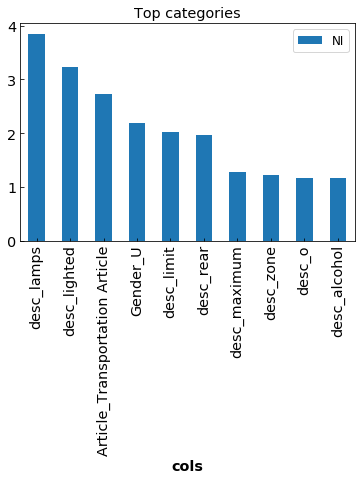

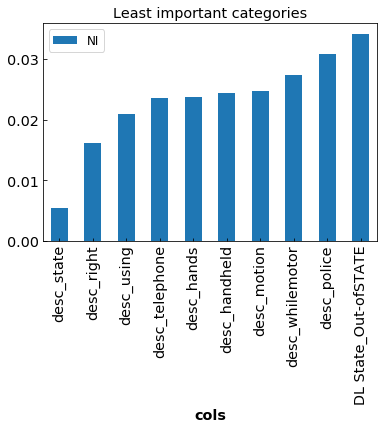

In [388]:
def non_neutrality_index(p1, p2):
    pmax = np.max([p1, p2])
    pmin = np.min([p1, p2])
    return pmax/pmin-1

df_traffic['extra_col'] = 0
col_of_interest = df_traffic.columns
col_of_interest = col_of_interest.drop(['Violation Type_Warning', 'extra_col', 'Latitude', 'Longitude', 'Year', 'Make',
                                        'Model', 'Color', 'datetime', 'V_Age', 'day', 'hour', 'Month'])

ni = list()
for col in col_of_interest:
    df = df_traffic.groupby([col, 'Violation Type_Warning']).count()
    
    prob1 = df.loc[(0, 0),'extra_col']/\
                    [df.loc[(0, 0),'extra_col'] +\
                     df.loc[(0, 1),'extra_col']]
    prob2 = df.loc[(1, 0),'extra_col']/\
                    [df.loc[(1, 0),'extra_col'] +\
                     df.loc[(1, 1),'extra_col']]
    
    ni.append(non_neutrality_index(prob1, prob2))
    

df_ni = pd.DataFrame({'cols': col_of_interest, 'NI': ni})

df_ni.sort_values('NI', ascending = False, inplace = True)
df_ni.iloc[:10,:].plot(kind = 'bar', x = 'cols', y = 'NI', rot = 90, title = 'Top categories')
plt.show()

df_ni.sort_values('NI', ascending = True, inplace = True)
df_ni.iloc[:10,:].plot(kind = 'bar', x = 'cols', y = 'NI', rot = 90, title = 'Least important categories')
plt.show()


The bar plot above provides ten most and ten least important categories to consider for machine learning. It also provides us a quantitative comparision between different features. 

## More on Racial/Gender Bias
In earlier anlaysis, we find that citation probability for white drivers is smaller than that for the drivers of other races. Does this mean that white are better drivers compared to others? or the police officers are racially biased on this category? Similar questions can be asked in the context of gender bias. 

To approach this question, we use a conditional citation probability. A driver is more likely to get citation if he commits a violation in a workzone, drives under the influence, properties damage, or involves in personal injury (these categories have the highest NI index among categorical features. When the drivers commit such mistakes, he/she is extremely likely to receive a traffic citation. We calculate the probability that a subgrop gets citation by commiting these crimes. 


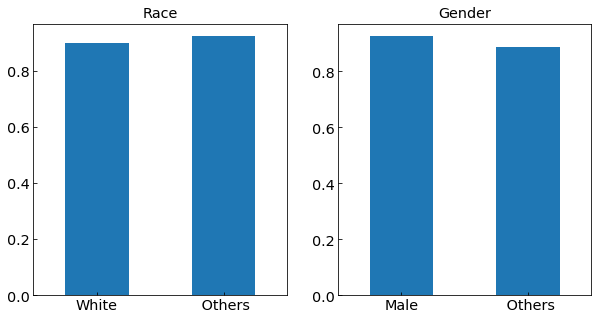

In [389]:
fig, axes = plt.subplots(nrows=1, ncols=2, squeeze=False, figsize = [10, 5])

major_reason = (df_traffic['Alcohol_Yes'] == 1) | (df_traffic['Contributed To Accident_Yes'] == 1)|\
                      (df_traffic['Work Zone_Yes'] == 1) | (df_traffic['Property Damage_Yes'] == 1) |\
                      (df_traffic['Personal Injury_Yes'] == 1)

# Racial bias ?
df = df_traffic[major_reason].groupby(['Race_non_white', 'Violation Type_Warning']).count()

prop_non_white = df.loc[(1, 0),'Belts_Yes']/\
                    [df.loc[(1, 0),'Belts_Yes'] + df.loc[(1, 1),'Belts_Yes']]
prop_white = df.loc[(0, 0),'Belts_Yes']/\
                    [df.loc[(0, 0),'Belts_Yes'] + df.loc[(0, 1),'Belts_Yes']]

df1 = pd.DataFrame([prop_white, prop_non_white], index = ['White', ' Others'])

df1.plot(kind = 'bar', legend = False, rot = 0, title = 'Race', ax  = axes[0,0])

# Gender bias ?
df = df_traffic[major_reason].groupby(['Gender_M', 'Violation Type_Warning']).count()

prop_female = df.loc[(0, 0),'Belts_Yes']/\
                    [df.loc[(0, 0),'Belts_Yes'] +\
                     df.loc[(0, 1),'Belts_Yes']]
prop_male = df.loc[(1, 0),'Belts_Yes']/\
                    [df.loc[(1, 0),'Belts_Yes'] +\
                     df.loc[(1, 1),'Belts_Yes']]

df1 = pd.DataFrame([prop_male, prop_female], index = ['Male', ' Others'])
s2 = df1.plot(kind = 'bar', legend = False, rot = 0, title = 'Gender', ax = axes[0,1])

plt.show()

When we consider the probability of getting a citation for the same level of violations, the racial and gender bias is much smaller. However, it is important that for the same amount of violations, Male drivers are more likely to get a traffic citations compared to female drivers, and similarly, white drivers are less likely to receive a citation compared to the drivers of other races. 

We will test the statistical significance of this result in next section. 